In [111]:
%load_ext autoreload
%autoreload 2

In [155]:
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize
import nltk.stem as stem
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from gensim.models import Word2Vec
import gensim
from sklearn.preprocessing import OneHotEncoder
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import category_encoders as ce
from sklearn.preprocessing import normalize
from sklearn.neural_network import MLPRegressor

In [156]:
data_train = "Data_Train.csv"
data_test = "Data_Test.csv"

In [157]:
df_train = pd.read_csv("Data/" + data_train)
df_testing = pd.read_csv("Data/" + data_test)
df_train.head()

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,"Paperback,– 10 Mar 2016",4.0 out of 5 stars,8 customer reviews,THE HUNTERS return in their third brilliant no...,Action & Adventure (Books),Action & Adventure,220.00
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,"Paperback,– 7 Nov 2012",3.9 out of 5 stars,14 customer reviews,A layered portrait of a troubled genius for wh...,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93
2,Leviathan (Penguin Classics),Thomas Hobbes,"Paperback,– 25 Feb 1982",4.8 out of 5 stars,6 customer reviews,"""During the time men live without a common Pow...",International Relations,Humour,299.00
3,A Pocket Full of Rye (Miss Marple),Agatha Christie,"Paperback,– 5 Oct 2017",4.1 out of 5 stars,13 customer reviews,A handful of grain is found in the pocket of a...,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00
4,LIFE 70 Years of Extraordinary Photography,Editors of Life,"Hardcover,– 10 Oct 2006",5.0 out of 5 stars,1 customer review,"For seven decades, ""Life"" has been thrilling t...",Photography Textbooks,"Arts, Film & Photography",965.62


Text variables : Title, sysnopsis

Categorical : Author, genre, bookCategory

composite (categorical) : Edition

real valued: Reviews, ratings

In [158]:
df_train.shape

(6237, 9)

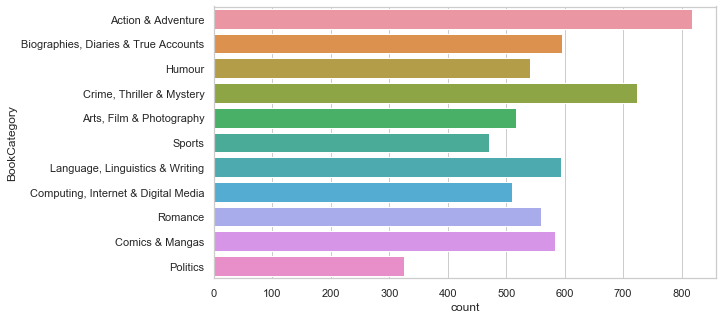

In [159]:
fig, ax = plt.subplots(figsize=(9,5))
sns.set(style="whitegrid")
sns.countplot(ax=ax, y="BookCategory", data=df_train)
plt.show()

In [160]:
def prepare_data(df_train):
    ''' cleaning data - fields Reviews, Ratings and Edtition'''
    
    df_train['Ratings'] = df_train.Ratings.str.split().str.get(0).str.replace(',', '').astype('int32')
    df_train['Reviews'] = df_train.Reviews.str.split().str.get(0).astype('float')
    df_train['Edition_type'] = df_train.Edition.str.split(',').str.get(0)
    df_train['Edition_year'] = df_train.Edition.str.split().str.get(-1)
    df_train = df_train.drop(columns=['Edition'])
    return df_train

In [161]:
df = prepare_data(df_train)
df.to_csv("Data/new_data.csv", index=None)

In [162]:
data = pd.read_csv("Data/new_data.csv")

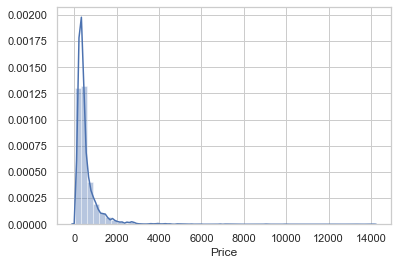

In [163]:
sns.distplot(data['Price']);
plt.show()

#### As we can see that the price distribution is a bit skewed, and there are several outliers as well.

In [164]:
# Removing outliers
data = data.loc[(data['Price'] <= 900) & (data['Price'] >=200)]

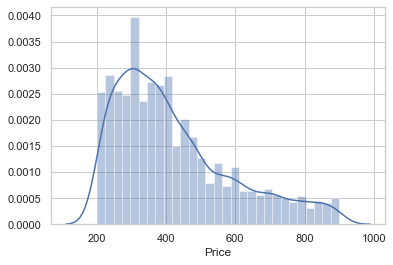

In [165]:
sns.distplot(data['Price']);
plt.show()

In [166]:
data.shape

(4419, 10)

### Add Synopsis as average word vectors to the features

In [80]:
stemmer = stem.PorterStemmer()
stop_words = stopwords.words('english')

def stem_stop(input_text):
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(input_text.lower())
    tokens = [x for x in tokens if not x in stop_words]
    tokens_stemmed = [stemmer.stem(x) for x in tokens]
    return tokens_stemmed

def get_mean_vector(word2vec_model, words):
    words = [word for word in words if word in word2vec_model.vocab]
    if len(words) >= 1:
        return np.mean(word2vec_model[words], axis=0)
    else:
        return np.zeroes(300)

def get_word_vectors(df):
    sentences_train = list(df)
    sentences_train = [stem_stop(i) for i in sentences_train]
    sentences_train = np.array([get_mean_vector(model, i) for i in sentences_train])
    headers = ["Wordvec"+ str(i) for i in range(300)]
#     sentences_train = pd.DataFrame(data=sentences_train, columns=headers)
    return sentences_train


model = gensim.models.KeyedVectors.load_word2vec_format('models/GoogleNews-vectors-negative300.bin', binary=True)
sentences = get_word_vectors(data['Synopsis'])
headers = ["Wordvec"+ str(i) for i in range(300)]
sentences = pd.DataFrame(data=sentences , index=data.index, columns=headers)
data = pd.concat([data, sentences], axis=1)

In [167]:
data = data.drop(columns=['Title', 'Synopsis'])
data.shape, data.columns

((4419, 8),
 Index(['Author', 'Reviews', 'Ratings', 'Genre', 'BookCategory', 'Price',
        'Edition_type', 'Edition_year'],
       dtype='object'))

In [208]:
Y = data['Price']
X = data.drop(columns=['Price'])

#### Using Binary encoding for categorical variables

In [209]:
ce_bin = ce.BinaryEncoder(cols = ['BookCategory','Edition_year', 'Genre','Author','Edition_type'])
X = ce_bin.fit_transform(X, Y)

In [210]:
X = normalize(X)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((3535, 42), (884, 42), (3535,), (884,))

#### importing Decision tree regressor with max depth = 3

In [211]:
reg_model = DecisionTreeRegressor(max_depth=3)

reg_model.fit(x_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [212]:
print("Train error: ", np.sqrt(mean_squared_log_error(y_train, reg_model.predict(x_train))))

predictions = list(reg_model.predict(x_test))

print("Test error: ", np.sqrt(mean_squared_log_error(y_test, predictions)))

Train error:  0.36032709413397573
Test error:  0.37074260834657924


In [223]:
def plot_train_test_error(x_train, y_train, x_test, y_test, encoding_type):

    train_errors, test_errors, depths = [], [], []

    for depth in range(2, 30):
        reg_model = DecisionTreeRegressor(max_depth=depth)
        reg_model.fit(x_train, y_train)
        train_err = np.sqrt(mean_squared_log_error(y_train, reg_model.predict(x_train)))
        test_err = np.sqrt(mean_squared_log_error(y_test, reg_model.predict(x_test)))
        train_errors.append(train_err)
        test_errors.append(test_err)
        depths.append(depth)

    d = pd.DataFrame({"train_error": train_errors, "test_error": test_errors, "depths": depths})

    builds = d['depths']
    y_stack = np.row_stack((d['train_error'], d['test_error'])) 
    fig = plt.figure(figsize=(12,5))
    fig.suptitle('Train test error with ' + encoding_type + ' encoded categorical Variables', fontsize=15)
    ax1 = fig.add_subplot(111)

    ax1.plot(builds, y_stack[0,:], label='Train error', color='c', marker='o')
    ax1.plot(builds, y_stack[1,:], label='Test error', color='g', marker='.')

    plt.xticks(builds)
    plt.xlabel('Depth')
    plt.ylabel('Error')

    handles, labels = ax1.get_legend_handles_labels()
    lgd = ax1.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.15,1))
    ax1.grid('on')

    plt.show()

#### Plot train test error for Decision tree regressor with varying max depths

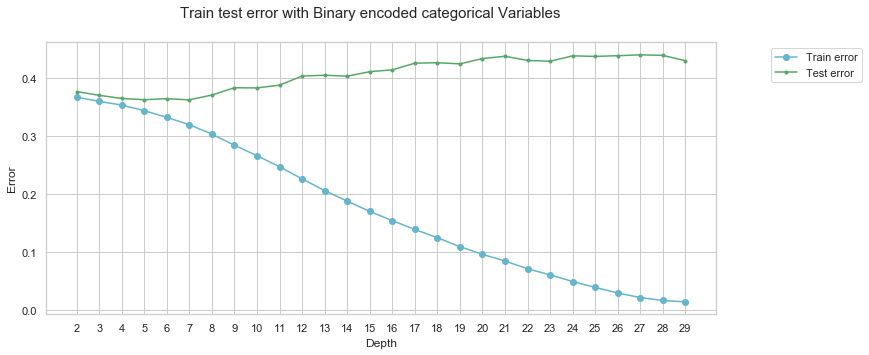

In [224]:
plot_train_test_error(x_train, y_train, x_test, y_test, 'Binary')

In [225]:
Y = data['Price']
X = data.drop(columns=['Price'])

#### Using one hot encoding for categorical variables

In [226]:
ce_bin = ce.OneHotEncoder(cols = ['BookCategory','Edition_year', 'Genre','Author','Edition_type'])
X = ce_bin.fit_transform(X, Y)

In [227]:
X = normalize(X)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((3535, 3058), (884, 3058), (3535,), (884,))

#### importing Decision tree regressor with max depth = 3

In [228]:
reg_model = DecisionTreeRegressor(max_depth=3)

reg_model.fit(x_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [229]:
print("Train error: ", np.sqrt(mean_squared_log_error(y_train, reg_model.predict(x_train))))

predictions = list(reg_model.predict(x_test))

print("Test error: ", np.sqrt(mean_squared_log_error(y_test, predictions)))

Train error:  0.36041400120046707
Test error:  0.3671667640630558


#### Plot train test error for Decision tree regressor with varying max depths

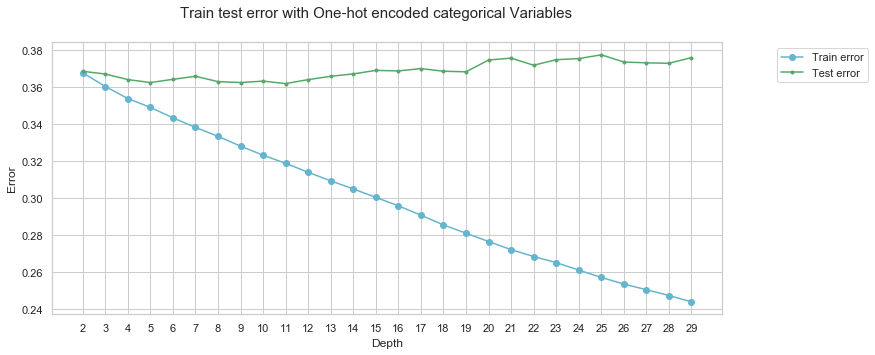

In [230]:
plot_train_test_error(x_train, y_train, x_test, y_test, 'One-hot')

we can see that model overfits badly as we increase the depth of tree.

#### Trying multi-layer perceptron regressor

In [98]:
reg_model = MLPRegressor(verbose=True, max_iter=6000, learning_rate_init=0.001, hidden_layer_sizes=(100, 3))

In [99]:
reg_model.fit(x_train, y_train)

Iteration 1, loss = 103168.02922915
Iteration 2, loss = 103125.50899104
Iteration 3, loss = 103050.98959536
Iteration 4, loss = 102923.77318207
Iteration 5, loss = 102722.17740990
Iteration 6, loss = 102420.99478645
Iteration 7, loss = 101994.67626413
Iteration 8, loss = 101413.09245415
Iteration 9, loss = 100649.07930481
Iteration 10, loss = 99670.34890959
Iteration 11, loss = 98456.87650836
Iteration 12, loss = 96982.41406474
Iteration 13, loss = 95210.73731307
Iteration 14, loss = 93158.47584506
Iteration 15, loss = 90779.33007757
Iteration 16, loss = 88108.87142489
Iteration 17, loss = 85113.18733830
Iteration 18, loss = 81854.96526770
Iteration 19, loss = 78319.11393136
Iteration 20, loss = 74524.46185774
Iteration 21, loss = 70544.52062754
Iteration 22, loss = 66405.71145174
Iteration 23, loss = 62128.05220037
Iteration 24, loss = 57812.82585714
Iteration 25, loss = 53506.51663881
Iteration 26, loss = 49253.07120216
Iteration 27, loss = 45150.22526347
Iteration 28, loss = 41189.5

Iteration 229, loss = 12310.56973043
Iteration 230, loss = 12302.49297213
Iteration 231, loss = 12298.27538056
Iteration 232, loss = 12296.13301048
Iteration 233, loss = 12286.36072166
Iteration 234, loss = 12283.32280190
Iteration 235, loss = 12276.21679078
Iteration 236, loss = 12271.76309342
Iteration 237, loss = 12266.55171273
Iteration 238, loss = 12261.00627648
Iteration 239, loss = 12254.76400347
Iteration 240, loss = 12248.96051638
Iteration 241, loss = 12244.45920286
Iteration 242, loss = 12240.23161624
Iteration 243, loss = 12237.78635911
Iteration 244, loss = 12228.85897534
Iteration 245, loss = 12224.36536205
Iteration 246, loss = 12217.77145659
Iteration 247, loss = 12213.26423708
Iteration 248, loss = 12207.97394593
Iteration 249, loss = 12203.22531791
Iteration 250, loss = 12198.50240600
Iteration 251, loss = 12195.73704541
Iteration 252, loss = 12193.44761421
Iteration 253, loss = 12187.95815567
Iteration 254, loss = 12177.79081088
Iteration 255, loss = 12173.84725331
I

Iteration 453, loss = 11529.11672705
Iteration 454, loss = 11524.76220520
Iteration 455, loss = 11526.64792786
Iteration 456, loss = 11519.09390807
Iteration 457, loss = 11517.29889605
Iteration 458, loss = 11515.06254662
Iteration 459, loss = 11513.19692976
Iteration 460, loss = 11512.64000506
Iteration 461, loss = 11509.72730258
Iteration 462, loss = 11506.70194608
Iteration 463, loss = 11505.23690003
Iteration 464, loss = 11504.13775493
Iteration 465, loss = 11503.40036220
Iteration 466, loss = 11498.60971426
Iteration 467, loss = 11494.39699326
Iteration 468, loss = 11492.80167463
Iteration 469, loss = 11493.21151989
Iteration 470, loss = 11496.84423284
Iteration 471, loss = 11484.80578839
Iteration 472, loss = 11485.16827253
Iteration 473, loss = 11481.37595243
Iteration 474, loss = 11479.44919741
Iteration 475, loss = 11476.23219659
Iteration 476, loss = 11474.19383305
Iteration 477, loss = 11472.79326834
Iteration 478, loss = 11471.01419788
Iteration 479, loss = 11470.17864792
I

Iteration 679, loss = 11039.11389028
Iteration 680, loss = 11035.74335992
Iteration 681, loss = 11035.62608095
Iteration 682, loss = 11031.11265253
Iteration 683, loss = 11030.03280996
Iteration 684, loss = 11026.62148933
Iteration 685, loss = 11025.15210324
Iteration 686, loss = 11022.78533218
Iteration 687, loss = 11022.41730654
Iteration 688, loss = 11031.24807890
Iteration 689, loss = 11023.13051811
Iteration 690, loss = 11014.18531231
Iteration 691, loss = 11014.08786576
Iteration 692, loss = 11009.94428206
Iteration 693, loss = 11009.22064034
Iteration 694, loss = 11006.55701835
Iteration 695, loss = 11004.87755041
Iteration 696, loss = 11001.75143412
Iteration 697, loss = 11001.31552450
Iteration 698, loss = 10998.06749165
Iteration 699, loss = 10996.60667832
Iteration 700, loss = 10992.98314953
Iteration 701, loss = 10991.87327307
Iteration 702, loss = 10989.04085356
Iteration 703, loss = 10986.63067384
Iteration 704, loss = 10983.80986361
Iteration 705, loss = 10982.22421526
I

Iteration 901, loss = 10478.60538554
Iteration 902, loss = 10482.92785359
Iteration 903, loss = 10469.46062870
Iteration 904, loss = 10466.48533899
Iteration 905, loss = 10463.64237982
Iteration 906, loss = 10461.37272994
Iteration 907, loss = 10459.02363813
Iteration 908, loss = 10458.32149603
Iteration 909, loss = 10454.16696273
Iteration 910, loss = 10451.42326601
Iteration 911, loss = 10449.85941913
Iteration 912, loss = 10444.88054454
Iteration 913, loss = 10440.70264540
Iteration 914, loss = 10441.40790721
Iteration 915, loss = 10439.55895534
Iteration 916, loss = 10430.04745760
Iteration 917, loss = 10428.81637640
Iteration 918, loss = 10426.97894033
Iteration 919, loss = 10425.23458234
Iteration 920, loss = 10419.80118746
Iteration 921, loss = 10419.92081652
Iteration 922, loss = 10410.99121641
Iteration 923, loss = 10409.88664057
Iteration 924, loss = 10407.32468372
Iteration 925, loss = 10404.64620481
Iteration 926, loss = 10404.08384873
Iteration 927, loss = 10396.90255909
I

Iteration 1122, loss = 9765.70046127
Iteration 1123, loss = 9770.85912285
Iteration 1124, loss = 9768.67701524
Iteration 1125, loss = 9757.40060643
Iteration 1126, loss = 9748.91114375
Iteration 1127, loss = 9748.65182103
Iteration 1128, loss = 9744.52622694
Iteration 1129, loss = 9746.16596178
Iteration 1130, loss = 9748.06960486
Iteration 1131, loss = 9736.28717104
Iteration 1132, loss = 9734.37267886
Iteration 1133, loss = 9729.83927482
Iteration 1134, loss = 9732.31177675
Iteration 1135, loss = 9727.78119371
Iteration 1136, loss = 9722.85751615
Iteration 1137, loss = 9714.82612815
Iteration 1138, loss = 9724.25328196
Iteration 1139, loss = 9735.22985997
Iteration 1140, loss = 9717.61074841
Iteration 1141, loss = 9708.99161451
Iteration 1142, loss = 9699.70241081
Iteration 1143, loss = 9698.72240976
Iteration 1144, loss = 9708.85996535
Iteration 1145, loss = 9711.22580688
Iteration 1146, loss = 9697.71828500
Iteration 1147, loss = 9706.67582992
Iteration 1148, loss = 9690.48171682
I

Iteration 1344, loss = 9083.24807024
Iteration 1345, loss = 9084.11209653
Iteration 1346, loss = 9077.46520249
Iteration 1347, loss = 9087.03049855
Iteration 1348, loss = 9071.85215660
Iteration 1349, loss = 9068.47610758
Iteration 1350, loss = 9065.65365988
Iteration 1351, loss = 9062.37150405
Iteration 1352, loss = 9062.12875926
Iteration 1353, loss = 9059.79563352
Iteration 1354, loss = 9054.64339652
Iteration 1355, loss = 9053.36527124
Iteration 1356, loss = 9049.95132622
Iteration 1357, loss = 9044.95113180
Iteration 1358, loss = 9043.27460737
Iteration 1359, loss = 9049.89760501
Iteration 1360, loss = 9043.89950496
Iteration 1361, loss = 9051.19739895
Iteration 1362, loss = 9032.52978122
Iteration 1363, loss = 9029.78980638
Iteration 1364, loss = 9026.57321964
Iteration 1365, loss = 9026.95320332
Iteration 1366, loss = 9021.34207427
Iteration 1367, loss = 9021.53493254
Iteration 1368, loss = 9016.36384115
Iteration 1369, loss = 9013.60108547
Iteration 1370, loss = 9010.86844645
I

/Users/preritgarg/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:568: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100, 3), learning_rate='constant',
             learning_rate_init=0.001, max_iter=6000, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=True, warm_start=False)

In [100]:
print("Train error: ", np.sqrt(mean_squared_log_error(y_train, reg_model.predict(x_train))))

Train error:  0.3026050727299889


In [101]:
predictions = list(reg_model.predict(x_test))

In [102]:
print("Test error: ", np.sqrt(mean_squared_log_error(y_test, predictions)))

Test error:  0.35402400422880387
